# Lidar with Rotation

<a href="https://colab.research.google.com/github/LinkHS/Colab/blob/main/IMU/Lidar_with_rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as sciR

## 基本知识

### 线速度
$\omega$为角速度（三维向量），$r$为旋转半径（三维向量），那么线速度为：

$$
\dot{r} = \omega \times r
$$

E.g.，假设IMU围绕x轴旋转，如果某点位于x轴上，此时该点旋转半径r和x轴重合，其线速度为0：

![](https://images-picgo.oss-cn-shanghai.aliyuncs.com/images/Colab/20210812154247.png)

In [2]:
r = [1, 0, 0]
w = [2, 0, 0] # 逆时针为正，右手法则

np.cross(w, r)

array([0, 0, 0])

若某物体在该点$(1, 0, 0)$的姿态和IMU姿态一致（即$R$为单位阵），其角速度应该等于IMU角速度：

$$
\omega' = R \omega
$$

In [3]:
R = np.eye(3, 3)
R @ w

array([2., 0., 0.])

E.g.，假设IMU围绕y轴逆时针旋转，如果某点位于x轴上，其线速度方向应该为z轴的负方向：

![](https://images-picgo.oss-cn-shanghai.aliyuncs.com/images/Colab/20210812154709.png)

In [4]:
r = [1, 0, 0]
w = [0, 2, 0]

np.cross(w, r)

array([ 0,  0, -2])

## 角速度和自身坐标系关系
角速度的积分得到的旋转向量$\phi=\boldsymbol{\omega}_{k-1}\left(t_{k}-t_{k-1}\right)$为$t_k$变换到$t_{k-1}$下的变换，而不需要求逆！因为此时是坐标系变换，等于参考向量被反向旋转。

例如IMU（坐标系）围绕自身x轴转90度（新x轴不变，新y轴为原来z轴，新z轴为原来-y轴），那么原来坐标系中的向量$[0, 1, 0]$在新的坐标系下表示为$[0, 0, -1]$，对$[0, 0, -1]$做变换看是否等于原向量$[0, 1, 0]$：

In [5]:
from scipy.spatial.transform import Rotation as sciR
R = sciR.from_rotvec(np.pi/2 * np.array([1, 0, 0]))

R.apply([0, 0, -1]).round()

array([ 0.,  1., -0.])

## 汽车拐弯模拟

假设汽车以$10 \text{m/s}$速度和$30^\circ \text{/s}$角速度拐弯：

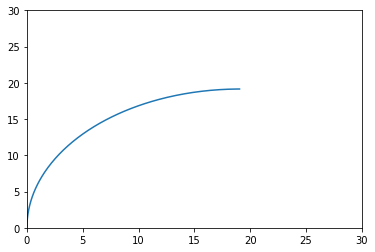

In [6]:
import matplotlib.pyplot as plt

w = np.array([0., 0., np.deg2rad(30)]) # 角速度
v = np.array([0., 10.0, 0.]) # 线速度 m/s
p = np.array([0., 0., 0.]) # 位置
dt = 0.01 # second

p_hst = [] # history of position
for i in range(300):
  R = sciR.from_rotvec(i*w*dt)
  p = p + R.inv().apply(v) * dt
  p_hst.append(p)
p_hst = np.array(p_hst)


plt.plot(p_hst[:, 0], p_hst[:, 1])
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.show()

上面求当前旋转矩阵时是先求出相对$t_0$时刻转过的角度（$w_1 \cdot \Delta t_1 + w_2 \cdot \Delta t_2 +\ ......$），代码里假设了角速度和时间间隔不变：

`R = sciR.from_rotvec(i*w*dt)`

实际使用时应该采用积分形式，例如下面是旋转矩阵积分：

$$
R_t = R_{t-1} e^{\phi_\times}
$$

对应代码`R = R * sciR.from_rotvec(w*dt)`。

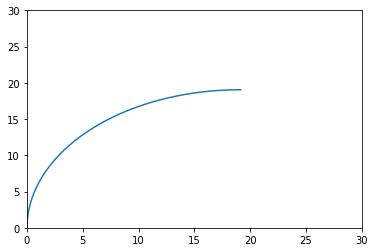

In [7]:
import matplotlib.pyplot as plt

w = np.array([0., 0., np.deg2rad(30)]) # 角速度
v = np.array([0., 10.0, 0.]) # 线速度 m/s
p = np.array([0., 0., 0.]) # 位置
dt = 0.01 # second

R = sciR.from_rotvec([0., 0., 0.])

p_hst = [] # history of position
for i in range(300):
  R = R * sciR.from_rotvec(w*dt)
  p = p + R.inv().apply(v) * dt
  p_hst.append(p)
p_hst = np.array(p_hst)


plt.plot(p_hst[:, 0], p_hst[:, 1])
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.show()

## 4D雷达

### 雷达转动和位移的影响
Aqronos雷达扫描方式是4微秒一个点，所以点云是在时序上扫描得到的，对应一组连续的雷达坐标系。

![](https://images-picgo.oss-cn-shanghai.aliyuncs.com/images/Colab/20210812160250.png)

计算一个刚体的运动速度需要利用该刚体上多点的位置和速度信息，因此需要把所有的点转换到同一个坐标系中表示，这样各点的相对位置才准确。

![](https://images-picgo.oss-cn-shanghai.aliyuncs.com/images/Colab/20210812160339.png)

设三维空间中一个目标点在$t_1$时刻雷达坐标系下为$\vec{p}_1$，将该点转换到$t_0$时刻雷达坐标系下为：

$$
\vec{p}_0 = R_1\vec{p}_1 + \vec{l}
$$

其中$R_1$为雷达坐标系$t_1$时刻相对$t_0$时刻的姿态，$l$为雷达位移。两边同时对求导可得：

$$\vec{v}_0 = \dot{R}_1\vec{p}_1 + R_1\vec{v}_1 + \vec{v}_l$$

其中$\dot{R} = R \omega_{\times},\ (\omega \times \vec{a} = \omega_{\times}a)$。

由于雷达测量点的速度$v'_1$为该点相对雷达的速度在雷达发射方向上的投影$v'_1 = \vec{p}_1 \cdot \vec{v}_1$，带入上面公式可得：

$$\vec{p}_1 R_1^T \vec{v}_0 = (\omega \times \vec{p}_1) \cdot \vec{p}_1 + v'_1 + (R_1^T\vec{v}_l) \cdot \vec{p}_1$$

由于$(\omega \times \vec{p}_1) \cdot \vec{p}_1 = 0$，而$(R_1^T\vec{v}_l) \cdot \vec{p}_1$相当于汽车速度在雷达发射方向上的投影，移项得到：

$$
(\vec{p}_1 R_1^T) \cdot (\vec{v}_0 - \vec{v}_l) = v'_1 
$$

同理可得其他点，并组成$Ax = B$的形式（这里假设雷达速度$\vec{v}_l$不发生变化）：

$$
\begin{bmatrix}
\vec{p}_1 R_1^T \\
\vec{p}_2 R_2^T \\
\vdots \\
\vec{p}_n R_n^T
\end{bmatrix} (\vec{v}_0 - \vec{v}_l) = 
\begin{bmatrix}
v'_1\\
v'_2\\
\vdots \\
v'_n
\end{bmatrix}
$$

In [8]:
def generatePoints(xc, yc, zc, n, xs=1, ys=1, zs=1):
  """
  @xc, yc, zc: points center
  @xs, ys, zs: points scale
  """
  points = np.random.rand(3, n)
  points[0] = points[0]*xs + xc
  points[1] = points[1]*ys + yc
  points[2] = points[2]*zs + zc
  return points

generatePoints(10, 50, 1, n=2)

array([[10.31871359, 10.2151918 ],
       [50.2594425 , 50.140402  ],
       [ 1.8613003 ,  1.40457554]])

Simulator：

In [9]:
from scipy.spatial.transform import Rotation as sciR

class Simulator:
  def __init__(self, w, v, vt, p, dt):
    self.w = w # 角速度
    self.v = v # 雷达速度
    self.vt = vt # 目标速度
    self.p = p # 雷达起始位置
    self.dt = dt # 间隔时间
    self.R = sciR.from_rotvec([0., 0., 0.]) # 单位阵
  
  @staticmethod
  def generateTargetPoints(xc, yc, zc, n, xs=1, ys=1, zs=1):
    """
    @xc, yc, zc: points center
    @xs, ys, zs: points scale
    """
    points = np.random.rand(3, n)
    points[0] = points[0]*xs + xc
    points[1] = points[1]*ys + yc
    points[2] = points[2]*zs + zc
    return points # shape: 3 x n

  def run(self):
    w = self.w # 角速度
    v = self.v # 雷达速度 m/s
    vt = self.vt # 目标速度 v-target
    p = self.p # 雷达起始位置
    dt = self.dt # second
    tps = self.tps # target points

    R = sciR.from_rotvec([0., 0., 0.])
    A = []
    B = []
    for i in range(len(self.tps)):
      R = R * sciR.from_rotvec(w*dt)
      p = p + R.inv().apply(v) * dt
      tp = tps[:, i] + vt*dt # target point
      p_t = tp - p
      A.append(R.apply(p_t))
      B.append(R.inv().apply(vt-v)@p_t)
    return A, B

In [10]:
w = np.array([0., 0., np.deg2rad(30)]) # 角速度
v = np.array([0., 10.0, 0.]) # 雷达速度 m/s
vt = np.array([2., 0., 5.]) # 目标速度 v-target
p = np.array([0., 0., 0.]) # 雷达起始位置
dt = 0.01 # second

Sim = Simulator(w, v, vt, p, dt)
Sim.tps = Simulator.generateTargetPoints(10, 50, 1, n=10) # target points

A, B = Sim.run()

print("gt:", vt)
print("estimation:", (np.linalg.pinv(A)@B + v).round(2))

gt: [2. 0. 5.]
estimation: [2. 0. 5.]


如果不考虑旋转，看下求解的目标速度和真值（gt）的误差情况：

In [11]:
# !pip install jdc
import jdc

In [12]:
%%add_to Simulator

def run_no_rotation(self):
  w = self.w # 角速度
  v = self.v # 雷达速度 m/s
  vt = self.vt # 目标速度 v-target
  p = self.p # 雷达起始位置
  dt = self.dt # second
  tps = self.tps # target points

  R = sciR.from_rotvec([0., 0., 0.])
  A = []
  B = []
  for i in range(len(self.tps)):
    R = R * sciR.from_rotvec(w*dt)
    p = p + R.inv().apply(v) * dt
    tp = tps[:, i] + vt*dt # target point
    p_t = tp - p
    A.append(p_t)
    B.append(R.inv().apply(vt-v)@p_t)
  return A, B

In [13]:
A, B = Sim.run_no_rotation()

print("gt:", vt)
print("estimation:", (np.linalg.pinv(A)@B + v).round(2))

gt: [2. 0. 5.]
estimation: [11.57 -2.18 11.27]


In [14]:
Sim.w = np.array([0., 0., np.deg2rad(30)]) # 角速度
Sim.v = np.array([0., 10.0, 0.]) # 雷达速度 m/s
Sim.vt = np.array([20., 30., 5.]) # 目标速度 v-target
Sim.dt = 0.00004 # 40us
A, B = Sim.run_no_rotation()

print("gt:", Sim.vt)
print("estimation:", (np.linalg.pinv(A)@B + Sim.v).round(3))

gt: [20. 30.  5.]
estimation: [20.133 29.97   5.084]


In [15]:
Sim.w = np.array([0., 0., np.deg2rad(30)]) # 角速度
Sim.v = np.array([0., 60.0, 0.]) # 雷达速度 m/s
Sim.vt = np.array([20., 30., 5.]) # 目标速度 v-target
Sim.dt = 0.00004 # 40us
A, B = Sim.run_no_rotation()

print("gt:", Sim.vt)
print("estimation:", (np.linalg.pinv(A)@B + Sim.v).round(3))

gt: [20. 30.  5.]
estimation: [20.215 29.951  5.138]


In [16]:
Sim.w = np.array([0., 0., np.deg2rad(10)]) # 角速度
Sim.v = np.array([0., 60.0, 0.]) # 雷达速度 m/s
Sim.vt = np.array([20., 30., 5.]) # 目标速度 v-target
Sim.dt = 0.00004 # 40us
A, B = Sim.run_no_rotation()

print("gt:", Sim.vt)
print("estimation:", (np.linalg.pinv(A)@B + Sim.v).round(3))

gt: [20. 30.  5.]
estimation: [20.072 29.984  5.046]


In [17]:
Sim.w = np.array([0., 0., np.deg2rad(30)]) # 角速度
Sim.v = np.array([0., 10.0, 0.]) # 雷达速度 m/s
Sim.vt = np.array([20., 30., 5.]) # 目标速度 v-target
Sim.dt = 0.001 # 1ms
A, B = Sim.run_no_rotation()

print("gt:", Sim.vt)
print("estimation:", (np.linalg.pinv(A)@B + Sim.v).round(3))

gt: [20. 30.  5.]
estimation: [23.385 29.235  7.141]


In [18]:
Sim.w = np.array([0., 0., np.deg2rad(30)]) # 角速度
Sim.v = np.array([0., 60.0, 0.]) # 雷达速度 m/s
Sim.vt = np.array([0., 0., 1.]) # 目标速度 v-target
Sim.dt = 0.001 # 1ms
A, B = Sim.run_no_rotation()

print("gt:", Sim.vt)
print("estimation:", (np.linalg.pinv(A)@B + Sim.v).round(3))

gt: [0. 0. 1.]
estimation: [ 2.711 -0.615  2.788]


In [19]:
Sim.w = np.array([0., 0., np.deg2rad(5)]) # 角速度
Sim.v = np.array([0., 60.0, 0.]) # 雷达速度 m/s
Sim.vt = np.array([0., 0., 1.]) # 目标速度 v-target
Sim.dt = 0.001 # 1ms
A, B = Sim.run_no_rotation()

print("gt:", Sim.vt)
print("estimation:", (np.linalg.pinv(A)@B + Sim.v).round(3))

gt: [0. 0. 1.]
estimation: [ 0.454 -0.103  1.299]


In [20]:
Sim.w = np.array([0., 0., np.deg2rad(5)]) # 角速度
Sim.v = np.array([0., 60.0, 0.]) # 雷达速度 m/s
Sim.vt = np.array([20., 70., 1.]) # 目标速度 v-target
Sim.dt = 0.005 # 5ms
A, B = Sim.run_no_rotation()

print("gt:", Sim.vt)
print("estimation:", (np.linalg.pinv(A)@B + Sim.v).round(3))

gt: [20. 70.  1.]
estimation: [26.439 68.541  5.152]


由于Aqronos雷达目标是逐行扫描（100ms/帧），如果总共20行，那么意味着上下两条线上点的间隔能差5ms。从上述仿真结果可以看出，即使雷达转动速度很低（5°/s），对目标速度方向求解有较大影响。